In [20]:
from IPython.display import Image

In [21]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [22]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cpu


(344, 512, 3)


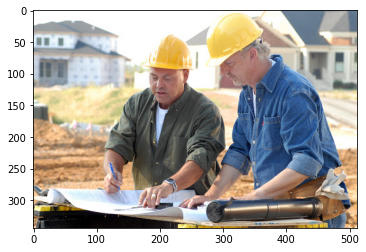

In [23]:
# 저희가 실험해 볼 사진
img0 = cv2.imread('/content/drive/My Drive/Colab Notebooks/unnamed.jpg')
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
print(img0.shape)
plt.imshow(img0)
plt.show() 

In [24]:
# 안전모를 detect 하는게 목적이며 먼저 object의 위치를 지정해줌. [ymin, xmin, ymax, xmax] and their labels 
bbox0 = np.array([[40, 170, 100, 250], [10, 270, 100, 370]]) 
labels = np.array([1, 1]) 
# 이때 labeling 은 다음과 같이 됨. 0: background, 1: helmet
# helmet 으로 지정된 1 을 다른 class 로 바꾸시면 다른 class 를 학습하게 됨

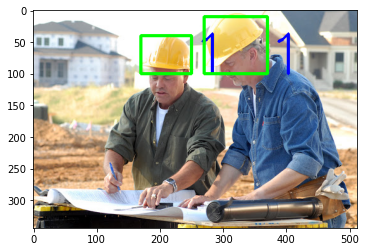

In [25]:
# box 의 위치를 시각화 하는 부분
img0_clone = np.copy(img0)
for i in range(len(bbox0)):
    cv2.rectangle(img0_clone, (bbox0[i][1], bbox0[i][0]), (bbox0[i][3], bbox0[i][2]), color=(0, 255, 0), thickness=3) 
    cv2.putText(img0_clone, str(int(labels[i])), (bbox0[i][3], bbox0[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255),thickness=3) 
plt.imshow(img0_clone)
plt.show()    

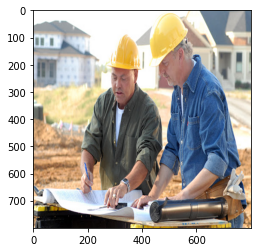

In [26]:
# input 의 모양에 맞게 size 를 조절해주어야 합니다.
# 이미지는 800 by 800으로 통일해줍니다.
img = cv2.resize(img0, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)
plt.imshow(img)
plt.show()

VGG NET 을 이용해서 이미지의 feature 을 뽑아냅니다.

In [27]:
# VGG NET으로 feature 을 추출하기 전 조절된 input size 의 비율에 맞게 bounding box 의 사이즈를 조절하는 구간
Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]
ratioLst = [Hratio, Wratio, Hratio, Wratio]
bbox = []
for box in bbox0:
    box = [int(a * b) for a, b in zip(box, ratioLst)] 
    bbox.append(box)
bbox = np.array(bbox)
print(bbox)

[[ 93 265 232 390]
 [ 23 421 232 578]]


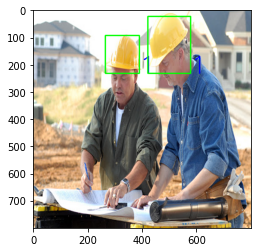

In [28]:
# 조절된 bounding box 의 그림을 그려봅니다.
img_clone = np.copy(img)
bbox_clone = bbox.astype(int)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    cv2.putText(img_clone, str(int(labels[i])), (bbox[i][3], bbox[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255),thickness=3) # Write the prediction class
plt.imshow(img_clone)
plt.show()    


In [29]:
#  VGG16 를 다운로드하고 모든 layer 를 출력한다.
model = torchvision.models.vgg16(pretrained=True).to(device)
fe = list(model.features)
print(len(fe)) # model 의 길이

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



31


In [30]:
fe

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1

In [32]:
# 목적 : VGG16의 conv layer를 지나 feature map 상태가 50x50x512로 만들기.
# 그러기 위해서는 VGG16의 conv layer 총 31개중 30개만 지나면 됨 -> 즉 마지막 Maxpooling 전까지 진행해서 feature map을 만들어줌
# 아래 코드는 layer 몇개를 지나야 되는지 확인하는 과정과 그 과정이 맞다면 output channel이 512개 나오는지 확인하는 코드임

In [33]:
# feature map 중 사이즈가 (W, H) < 50 인 것들만 가려낸다
# 논문 에서는 RESNET50을 이용하지만 idea는 같다. 
# output 은 50*50*512
dummy_img = torch.zeros((1, 3, 800, 800)).float() # test image array [1, 3, 800, 800] 
print(dummy_img.shape)

req_features = []
k = dummy_img.clone().to(device)
for i in fe:
    k = i(k)
    if k.size()[2] < 800//16:   #800/16=50
        break
    req_features.append(i)
    out_channels = k.size()[1]
print(len(req_features)) #30
print(out_channels) # 512

# 즉 vgg 를 지나면 입력이미지가 800 * 800 *3 -> 50*50*512 의 feature 가 된다.

torch.Size([1, 3, 800, 800])
30
512


In [34]:
# 이 리스트를 Sequential module 로 바꾸어줌
faster_rcnn_fe_extractor = nn.Sequential(*req_features)

In [35]:
#  한번 이미지가 어떻게 바뀌는지 넣어보았다.
# 이 때에 우리가 의도한 모양대로 바뀌는 모습 확인 가능
transform = transforms.Compose([transforms.ToTensor()])
imgTensor = transform(img).to(device) 
imgTensor = imgTensor.unsqueeze(0)
out_map = faster_rcnn_fe_extractor(imgTensor)
print(out_map.size())


torch.Size([1, 512, 50, 50])


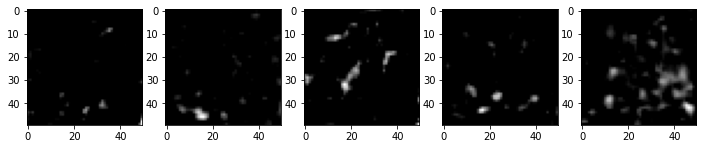

In [36]:
# feature map 시각화하기
# 사진은 vgg net 을 거쳐서 50 * 50 * 512 의 convolutional map 이 되는데 
# 이 때에 512채널 중 앞의 5개 filter 를 시각화해보았다.
imgArray=out_map.data.cpu().numpy().squeeze(0)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5): 
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(imgArray[i], cmap='gray')
    figNo +=1
plt.show()

In [37]:
# 엥커 박스를 만들기 위해서, 각 그림에 np.arange 를 이용해 같은 간격으로 점을 찍는다.
# RPN에서의 핵심인 anchor를 적용하려고 함 몇 개 설정하는건 내 맘인데 
#  일단 한 줄에 50개씩 anchor set만들자 -> 50 x 50 => 2,500개의 anchor set 점 (빨간점)이 찍힐거임
# 즉 아래들은 X 축에서의 anchor 좌표들
fe_size = (800//16)
ctr_x = np.arange(16, (fe_size+1) * 16, 16)
ctr_y = np.arange(16, (fe_size+1) * 16, 16)
print(len(ctr_x), ctr_x)

50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [38]:
# 위와 같이 생성한 50*50 개의 ancor 에서 2500개 생성
index = 0
ctr = np.zeros((2500, 2))
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[x] - 8
        ctr[index, 0] = ctr_y[y] - 8
        index +=1
print(ctr.shape)

(2500, 2)


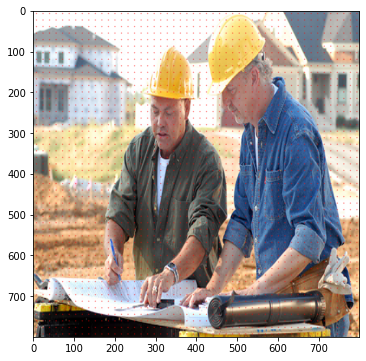

In [39]:
# 우리가 찍은 2500개의 ancor box 를 보여주기
img_clone = np.copy(img)
plt.figure(figsize=(9, 6))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone, (int(ctr[i][0]), int(ctr[i][1])), radius=1, color=(255, 0, 0), thickness=1) 
plt.imshow(img_clone)
plt.show()    


In [40]:
# 2500 개의 ancor 에서 , bounding box 를 생성한다.
# 그 비율은, 아래와 같이 random 의 비율로 정하는데
ratios = [0.5, 1, 2] # 사용자가 정하는 scale
scales = [8, 16, 32] # 사용자가 정하는 scale
sub_sample = 16
anchor_boxes = np.zeros( ((fe_size * fe_size * 9), 4))
index = 0
for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(ratios)): # ration
        for j in range(len(scales)): # scale 
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])
            anchor_boxes[index, 0] = ctr_y - h / 2.
            anchor_boxes[index, 1] = ctr_x - w / 2.
            anchor_boxes[index, 2] = ctr_y + h / 2.
            anchor_boxes[index, 3] = ctr_x + w / 2. 
            index += 1 
# 우리가 randolmy 정의한 box 의 모양대로 생성된 모습
# anchor box 는 4개의 좌표로 이루어져 있고, 2500 * 9  = 22500 개의 box 로 이루어짐
print(anchor_boxes.shape)

(22500, 4)


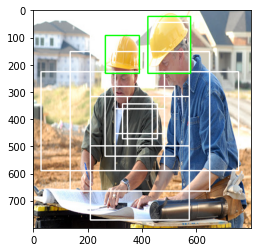

In [41]:
# 하나의 anchor 에 대한 random box 를 생성해보자.
# 1개의 anchor 에 대해 9개의 anchor box 가 생성되므로 9 개를 살펴보자.
#3가지 크기 * 3가지 비율로 9개 anchor box 생성된다 아래의 흰색 box로 확인할 수 있음
img_clone = np.copy(img)
for i in range(11025, 11034):  # 9*1225=11025
    x0 = int(anchor_boxes[i][1])
    y0 = int(anchor_boxes[i][0])
    x1 = int(anchor_boxes[i][3])
    y1 = int(anchor_boxes[i][2])
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(255, 255, 2550), thickness=3) 

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    
plt.imshow(img_clone)
plt.show()  


In [42]:
# 이제 RPN 학습시킬려는데 valid anchor box & ground truth boxes iou를 설정할 것임
#-> 22,500개의 anchor box 중에는 기존 우리의 이미지 밖으로 벗어나는 anchor box들도 존재할거임. 
#이런건 다 training에서 뺄거다, 그렇게 살아남은 valid 한 놈은 8940개다. 아래 코드가 그걸 확인 시켜줌

In [43]:
# 그런데 이 때에 ankor box 가 사진의 경계선을 벗어날 수 있다.
# 그래서 boundary 밖의 박스는 의미가 없으므로 제외해 주고 싶다.
index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) & # x=0 보다 클때
        (anchor_boxes[:, 1] >= 0) & # y=0 보다 클때
        (anchor_boxes[:, 2] <= 800) & # x=800 보다 작을때
        (anchor_boxes[:, 3] <= 800) # y = 800 보다 작을때
    )[0]
print(index_inside.shape)

valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape) 
# 그런 박스는 총 몇개일까?
# 8940 의 box 가 유효한 valid anchor box 임을알수있다.

(8940,)
(8940, 4)


In [44]:
# 유효한 anchor box 에 대해 iou 를 계산하자. (iou 는 겹치는 부분을 의미함)
# 우리는 8490 개의 유효한 anchor 박스와, 각
# iou 를 계산할 박스가 2개 이므로 결과값으로 (8940,2)의 배열을 얻어야 한다. 
ious = np.empty((len(valid_anchor_boxes), 2), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area+ box_area - iter_area)            
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)
# 아래와 같이 8940,2 의 dimension 의 값이 나오게 된다.

(8940, 2)


In [47]:
# 궁극적으로 gound truth box와 가장 높은 iou를 갖는 anchor 를 구하기 위해 다음 두가지 항목을 구한다
# 첫번째 : 각 ground truthbox의 가장 높은 iou와 이에 상응하는 anchor box를 구함
# the highest iou for each gt_box and its corresponding anchor box
# the highest iou for each anchor box and its corresponding ground truth box
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
#ground truth box와 가장 큰 iou 를 지니는 anchor box 의 위치
print(gt_argmax_ious)

[3209 5280]
[0.9009516  0.50068665]
[3209 5280 5526 5772 5789 5795 6018 6035 6041 6264 6510]


In [48]:
# 두번째 : 각 anchor box의 가장 높은 iou와 이에 상응하는 ground truth box를 구하는 방법
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)
max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)


(8940,)
[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]


In [49]:
# -1 은 ignore(RPN training 시)
label = np.empty((len(index_inside), ), dtype=np.int32)
label.fill(-1)
print(label.shape)


(8940,)


In [50]:
# 두가지 종류의 anchor 에 1(objective)을 부여함  
# a) ground truth box와 겹쳐 가장 높은 iou 를 지닌 anchor
# b) ground truth box와의 iou 값이 0.7보다 높은 anchor
# iou 값이 0.3 미만인 anchor에는 0(background)이 할당됨

pos_iou_threshold  = 0.7
neg_iou_threshold = 0.3
label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0



In [51]:
#  위의 threshold 비율로 전체 anchor를 가지고 loss를 최적화시키면 negative로 할당된 anchor가 많기 때문에 negative쪽으로 편향될 수 있음
#  postive와 negative anchor 비율을 1:1로 유지해 샘플링한 후 loss를 계산하는 방식으로 학습한다

n_sample = 256 # minibatch 크기
pos_ratio = 0.5 # 논문(비율상으로 generate)
n_pos = pos_ratio * n_sample # Total positive sample

pos_index = np.where(label == 1)[0] # positive sample
if len(pos_index) > n_pos: 
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
    label[disable_index] = -1
    
    
n_neg = n_sample * np.sum(label == 1) # negative sample
neg_index = np.where(label == 0)[0]
if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
    label[disable_index] = -1
# 배경이 너무 많으면 학습이 안된다는것을 기억하자. 

In [52]:
# anchor boxes 에 locations 할당
# 각 valid anchor box의 큰 iou 를 지니는 object 찾는 것이 목표이다.

max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)

# 우리는 이미 어떤 어떤 anchor box 가 큰 iou 를 가지는지 아래의 format을 바꿔주는 계산을 통해 알 수 있다.

# valid anchor boxes 의 h, w, cx, cy
# 높이, 너비, center coordinates
height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
ctr_y = valid_anchor_boxes[:, 0] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 1] + 0.5 * width

# max iou 지니는 valid anchor 의 bbox 에 해당하는 h, w, cx, cy 
base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width

# valid anchor boxes 의 loc = (y-ya/ha), (x-xa/wa), log(h/ha), log(w/wa)
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(anchor_locs.shape)
# 위 과정은 true answer for RPN TRAINING 과정이다.
# 위 값들은 TRUE Lableing 이 되어있는 상태이다.

(8940, 4)
(8940, 4)


In [53]:
# 이후의 과정은 training RPN 을 해 주기 위한 과정이다. 
# 우선 labeling 을 해주는데 -1(ignore) 할것
# Fianal Labels
anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape) 

# Final Locations
# location 은 4가지 좌표가 들어가야 한다.
anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0) # 우선 0
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)

(22500,)
(22500, 4)


In [54]:
in_channels = 512 # depends on the output feature map. in vgg 16 it is equal to 512
mid_channels = 512
n_anchor = 9  # Number of anchors at each location
# 아래 과정은 각 RPN 구조들에 대한 initialization setting 이다. (초깃값 및 구조화)

# 아래 과정은 어짜피 rpn 도 cnn 의 결과를 받아서, 그 결과를 다시 33 conv layer 적용후
# 33conv
# input channel , output channel , kernal size , stride , padding 순인데 3 지정했으니까 33
conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(device)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

# 11 layer 적용. 위와같은 padding 노필요(dim - 유지)
reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0).to(device)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

# 얘는 classification 이니까 위와 같은 size 를 적용하되, softmax 를 적용함을 유의
cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0).to(device) ## I will be going to use softmax here. you can equally use sigmoid if u replace 2 with 1.
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [55]:
x = conv1(out_map.to(device)) 
# out_map = faster_rcnn_fe_extractor(imgTensor) 으로 정의
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)
print(pred_anchor_locs.shape, pred_cls_scores.shape)
# location 에 대한 predict 와 classification 에 대한 predict score 은 어떤 차이가 있을까?
# 1*1 cov 를 2(오브젝트 인지 아닌지 나타내는 지표 수) * 9(앵커 수) 만큼 수행
# 그 결과로 H*W*18 의 피쳐맵을 얻는다. 18개의 체널은 각각 해당 좌표를 앵커로 삼는다.

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [56]:
# 아래 과정은 그냥 형식을 이전에 정의했던 형식과 맞추기 위함이다. 
# 위치 : [1, 36(9*4), 50, 50] => [1, 22500(50*50*9), 4] (dy, dx, dh, dw)
# classification : [1, 18(9*2), 50, 50] => [1, 22500, 2]  (1, 0)
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape) # 우리 RPN 모델의 location prdiction 모양새 (뒤에 4가 늘엇는데 이는 위치 정보임)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores  = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape) # 뒤에 2붙은건 classification


torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


In [57]:
print(pred_anchor_locs.shape) # rpn 의 pred 값
print(pred_cls_scores.shape) # rpn 의 pred (socre)
print(anchor_locations.shape) # 처음의 true location 들
print(anchor_labels.shape) # label
# 이게 RPN 의 출력과, 우리의 TRUE 값이 합쳐진것. 
# '학습' 을 해야되기 때문에 그 모양이 일치해야 한다. 
# conv 와 일치하게 만들었으므로 학습이 이제 가능하게됨.

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [58]:
# 그냥 위의 process를 하나에 대해서 계산해 보는 예시값 입니다. 
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]
gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)
print(rpn_loc.shape, rpn_score.shape, gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


In [59]:
# classification 을 위해서 cross entropy 를 사용하게 됩니다.
# 확률값이 나올 수 있게 해줍니다.
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(device), ignore_index = -1)
print(rpn_cls_loss)


tensor(0.6859, grad_fn=<NllLossBackward>)


In [60]:
# 논문에서 나온대로 REGRESSION 은 L1 loss 를 사용
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x-0.5))
print(rpn_loc_loss.sum()) 


torch.Size([22500, 4])
torch.Size([15, 4]) torch.Size([15, 4])
tensor(1.6456, dtype=torch.float64, grad_fn=<SumBackward0>)


In [61]:
#  rpn_cls_loss 와 rpn_reg_loss 를 합치는 부분
rpn_lambda = 10. # 이 람다값은 사용자가 정의하는 것입니다. (저희 논문에서 loss 정의할때의 lambda 입니다.)
N_reg = (gt_rpn_score >0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg #location 에 대한 loss
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss) # classification 과 , location 에 대한 loss 를 더하면
print(rpn_loss) # 저희가 의도한 loss 가 나옵니다.

tensor(1.7829, dtype=torch.float64, grad_fn=<AddBackward0>)


In [62]:
# Faster R-CNN에 대한 학습이 완료된 후, RPN 모델을 예측시키면 아마도 한 객체당 여러개의 proposals (bounding boxes) 값을 얻을 것 입니다. 
# 이유는 anchors자체가 어떤 객체에 중복이 되기 때문에 proposals 또한 여러개가 되는 것 입니다.
#문제를 해결하기 위해서 non-maximum suppression (NMS) 알고리즘을 사용해서 proposals의 갯수를 줄이도록 합니다. 
# NMS를 간단히 설명하면 먼저 IoU값으로 proposals을 모두 정렬시켜놓은뒤, RoI점수가 가장 높은 proposal과 다른 proposals에 대해서 overlapping을 비교한뒤 
# overlapping이 높은 것은 특정 threshold이상이면 지워버리며 이 과정을 iterate돌면서 삭제시킵니다.

In [63]:
# 이제 IoU를 바탕으로 0.7보다 크면 1, 0.3보다 작으면 0, 그 사이 값들은 -1로 할당해서 -1은 또 training에서 뺄거임
# 주의! 논문과 달랐던 점 : 논문에선 background를  negative로 하고  다시 negative를 0으로 했는데 여기는 좀 더 간소화 시켰습니다. 

In [64]:
# 그런데 중간에 NMS 라는것을 지나갑니다.
# anchor box 는 겹치는게 많기 때문에, 겹치는 box 들을 쳐내고 싶습니다. 
# 그 겹치는 box 들을 쳐내고, 중요하다고 여겨지는 box 를 남길 수 있게 해주는것이 NMS 입니다.

# 각각이 무엇을 의미하는지는 크게 살펴보지 않아도 되는데 [***] 값의 의미만 알고 넘어가면 될 것입니다.
nms_thresh = 0.7  # non-maximum supression (NMS) threshold [****] 
                  # 어느정도 겹치는 놈을 쳐낼것인지. 0.9 -> 두 샘플이 90% 는 겹쳐야 한놈을 쳐낼게(관대함) , 0.6 -> 두 샘플이 60% 만 겹쳐도 한놈 쳐낼게  
n_train_pre_nms = 12000 
n_train_post_nms = 2000 # 얼마나 RPN 에서 남길지 [****] 2000이면 2000개만 최종적으로 남기겠다는 것 입니다.
n_test_pre_nms = 6000
n_test_post_nms = 300 # 위와 의미는 같은데, 얘는 test 과정에서 남기는 녀석의 수 입니다.,
min_size = 16

In [65]:
# 그럼 어떻게 줄일까요? 
# 우선 RPN 이 제안한 location prdiction 을 저희 그림 위 좌표로 표현해 봅시다(아래 과정이 다 그 과정입니다.)

# format converted from [y1, x1, y2, x2] to [ctr_x, ctr_y, h, w]
anc_height = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_width = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_ctr_y = anchor_boxes[:, 0] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 1] + 0.5 * anc_width
print(anc_ctr_x.shape)

# The 22500 anchor boxes location and labels predicted by RPN (convert to numpy)
# format = (dy, dx, dh, dw)
pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()
dy = pred_anchor_locs_numpy[:, 0::4] # dy
dx = pred_anchor_locs_numpy[:, 1::4] # dx
dh = pred_anchor_locs_numpy[:, 2::4] # dh
dw = pred_anchor_locs_numpy[:, 3::4] # dw
print(dy.shape)

# ctr_y = dy predicted by RPN * anchor_h + anchor_cy
# ctr_x similar
# h = exp(dh predicted by RPN) * anchor_h
# w similar
ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
print(w.shape)

(22500,)
(22500, 1)
(22500, 1)


In [66]:
# 결국 아래 과정이 중요한것이므로 여기는 넘기겠습니다.
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_y - 0.5 * h
roi[:, 1::4] = ctr_x - 0.5 * w
roi[:, 2::4] = ctr_y + 0.5 * h
roi[:, 3::4] = ctr_x + 0.5 * w
print(roi.shape)

# clip the predicted boxes to the image
img_size = (800, 800) #Image size
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])
print(roi.shape, np.max(roi), np.min(roi))


(22500, 4)
(22500, 4) 800.0 0.0


In [67]:
# 너무 작은 predict box 는 일단 제거합니다.
hs = roi[:, 2] - roi[:, 0]
ws = roi[:, 3] - roi[:, 1]
keep = np.where((hs >= min_size) & (ws >= min_size))[0] #min_size=16
roi = roi[keep, :]

# 여기서 score 가 나오는데요, score 은 objectness_score 함수의 값 입니다. 
# score은 rpn network 에서 여기에 objct 가 있다고 판단할수록 높은 값을 줍니다.
# rpn 의 classification layer(0이면 배경 , 1이면 object) 에서 나온 score 이니까 당연히 object 가 있다고 판단파면 높은값을 주겠죠?
score = objectness_score_numpy[keep]
print(keep.shape, roi.shape, score.shape)

# 스코어가 높은 RPN 의 Proposal 부터 순차적로 배열시킵니다. (즉 objct 가 있다고 확신하는것부터)
order = score.ravel().argsort()[::-1]
print(order.shape)

# object score 가 높은 값을 우선 선택하겠다는 것 입니다. (e.g. 12000 while training and 300 while testing)
order = order[:n_train_pre_nms]
roi = roi[order, :]
print(order.shape, roi.shape, roi.shape)


(22500,) (22500, 4) (22500,)
(22500,)
(12000,) (12000, 4) (12000, 4)


In [68]:
# 이제 위에서 object 가 있을법하다고 생각되는 것들을 추렷죠?
# 그러면 이제 여기에서 또 겹칠것 같다고 생각되는 것들을 추려야 합니다.
# 일단 모든 roi box 들의 좌표를 가져옵니다.
y1 = roi[:, 0]
x1 = roi[:, 1]
y2 = roi[:, 2]
x2 = roi[:, 3]

# 모든 박스들의 area 를 측정합니다. [roi_area]
areas = (x2 - x1 + 1) * (y2 - y1 + 1)


In [69]:
# Take the indexes of order the probability score(즉 여기에 물체가 있다! 라고 느끼는 값) in descending order 
order = order.argsort()[::-1] # 물체가 겹칠거라고 판단되는 순서로 ordering 을 합니다.(즉 첫번째 element 는 모델이 제일 큰 확률로 물체를 포함하는 box라 판단)
keep = []
while (order.size > 0):
    i = order[0]  #일단 첫번째 element keep (제일 높은 확률로 object 가 있을거니까)
    keep.append(i)
    xx1 = np.maximum(x1[i], x1[order[1:]]) 
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])
    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)
    inter = w * h
    ovr = inter / (areas[i] + areas[order[1:]] - inter) # 지금 이 박스와 겹치는 area 를 찾아냅니다.
    inds = np.where(ovr <= nms_thresh)[0] # overlap 이 심한놈은 쳐냅니다. (num_thresh = 0.7 로 정했엇죠? 즉 0.7 이하로 겹쳐야 살아남는겁니다.)
    order = order[inds + 1] # 이 과정을 계속 반복
keep = keep[:n_train_post_nms] # 이제 n_train_post_nms 란 저희가 남기고 싶게 하는 값(2000 ) 이였습니다. 즉 2000개만 남깁니다.
roi = roi[keep] # final 제안
print(len(keep), roi.shape)
# 이 2000개의 input 이 남습니다. 
# 이 input 들은 overlap 이 적고 + object 가 있다고 판단한 소수 정예들 입니다.

2000 (2000, 4)


In [70]:
# 학습의 목적을 위해 2000개 ROI 중 128개의 ROI를 sampling하는데 positive는 총 32개
# Why? 학습 목표 : detection을 학습시키려는데 만약 물체가 없는 sample만 학습시키면 되나요? 정답이 있는 걸 학습시켜야 함
# 무얼 학습시킬거나면 이제는 RPN의 결과로 나온 것을 가지고 detector 역할을 하는 Fast R-CNN을 학습시키기 위해 지금 세팅 중임

In [71]:
n_sample = 128  # roi 에서 얻을 샘플 수
pos_ratio = 0.25 # n_sample 중에서 positive sample 의 비율
pos_iou_thresh = 0.5  # 이거 이상 ground truth(헬멧)와 겹치면 positive label 로 보겠다는 뜻
neg_iou_thresh_hi = 0.5  # iou 0~0.5 가 값이면 negative label(0, background)
neg_iou_thresh_lo = 0.0


In [72]:
#ground truth object 와, Region proposal 의 iou 계산 (resion proposal 이 2000개니까 2000번 계산하게 된다.)
# 각각이 헬멧과 얼마나 겹치는지 보고싶은것
ious = np.empty((len(roi), 2), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(roi):
    ya1, xa1, ya2, xa2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area+ box_area - iter_area)            
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)
# 헬멧이 2개 이기 때문에 그 출력은 (Region proposal, 헬멧 둘)  = (2000,2) 가 된다.

(2000, 2)


In [73]:
# Find out which ground truth has high IoU for each region proposal,
# 각각의 region proposal 마다 ground truth(헬멧둘) 의 iou 를 계산 
# 그리고 maximum 값을 계산한다.
gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)
print(gt_assignment)
print(max_iou) # 이 iou 값을 보면 0 (겹친게 없는 proposal) , 0.053 (조금겹침) .. 등이 나타남

# Assign the labels to each proposal
gt_roi_label = labels[gt_assignment]
print(gt_roi_label) 
# 각각의 proposal 에 label 을 붙여준다.
# 지금은 객체가 다 helmet 뿐이라 1뿐이긴 하다...

[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]
[1 1 1 ... 1 1 1]


In [74]:
# Select the foreground rois as per the pos_iou_thesh and 
# n_sample x pos_ratio (128 x 0.25 = 32) foreground samples.
pos_roi_per_image = 32 
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
if pos_index.size > 0:
    pos_index = np.random.choice(
        pos_index, size=pos_roi_per_this_image, replace=False)
print(pos_roi_per_this_image)
print(pos_index)

# Similarly we do for negitive (background) region proposals
neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                             (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))
if  neg_index.size > 0 :
    neg_index = np.random.choice(
        neg_index, size=neg_roi_per_this_image, replace=False)
print(neg_roi_per_this_image)
print(neg_index)

12
[ 845 1398 1347 1501  803  903  905 1394  809  909 1444 1304]
116
[ 798  249 1437  543 1128  783 1067 1520 1917 1916 1095  275  586 1011
  487 1399 1072  660  250 1186 1512   36  695  247 1844 1822 1591  710
 1654  785 1081  744 1603  587  277 1864 1261  211  538 1243  503  182
 1289  445  475  926 1093 1259 1352  625 1354 1446  122 1779 1090 1757
  326  841 1942  576 1487  793 1738 1087  449 1396  506 1606  159  942
  529 1356 1292  703  686 1125 1171  248 1793 1669  271  829 1880 1045
  334 1424 1263  999 1785 1464  260 1357 1704  185 1426 1529 1799 1875
  376  817 1526  837  597   81 1450  463  188   94  121 1627 1525  557
  424 1204 1166  212]


In [75]:
# 35~45 의 과정은 NMS 의 과정을 깊게 다룬것이 되었는데요, 그 과정을 SUMMARY 하면 다음과 같습니다.
# [35~39] : Region proposal 에서 object가 있을것이라고 판단한 상위 proposal 을 추리는 단계
# [40~41] : 추린 sample 중에서 proposal 이 너무 겹치면 안좋으니까, 겹치는 녀석을 쳐 내는 단계
# [42~45] : 남은 roi 중에서, 저희 모델을 학습시키려면 positive sample , nagative sample 이 필요하죠 ?
#         : 저희는 헬멧의 겹침으로 그 positive/negative 를 분류할거니까 헬멧이 겹치는애들 , 안겹치는 애들을 각각 pos,neg 로 분류해서 학습시키는데에 이용합니다.
# 이제는 저희가 분류한 positive / negative 를 봅시다.

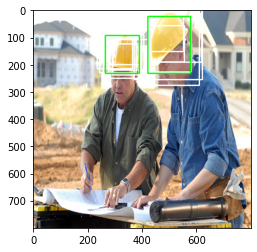

In [76]:
# display ROI samples with postive 
# Positive ROI sample의 예시들

img_clone = np.copy(img)
for i in range(pos_roi_per_this_image):
    y0, x0, y1, x1 = roi[pos_index[i]].astype(int)
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(255, 255, 2550), thickness=3) 

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    
plt.imshow(img_clone)
plt.show()  


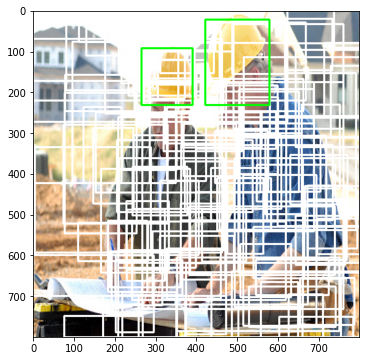

In [77]:
# display ROI samples with negative 
# Negative ROI sample의 예시들

img_clone = np.copy(img)
plt.figure(figsize=(9, 6))
for i in range(neg_roi_per_this_image):
    y0, x0, y1, x1 = roi[neg_index[i]].astype(int)
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(255, 255, 2550), thickness=3) 

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    
plt.imshow(img_clone)
plt.show()  


In [78]:
# positive sample과 negative sample을 합쳐 128개의 sample for training 준비완료
# 그 sample들에 대응하는 true 값 128개를 준비하는 과정

# Now we gather positve samples index and negitive samples index, 
# their respective labels and region proposals

keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0  # negative labels --> 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

# Pick the ground truth objects for these sample_roi and 
# later parameterize as we have done while assigning locations to anchor boxes in section 2.
bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

height = sample_roi[:, 2] - sample_roi[:, 0]
width = sample_roi[:, 3] - sample_roi[:, 1]
ctr_y = sample_roi[:, 0] + 0.5 * height
ctr_x = sample_roi[:, 1] + 0.5 * width

base_height = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_width = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_y = bbox_for_sampled_roi[:, 0] + 0.5 * base_height
base_ctr_x = bbox_for_sampled_roi[:, 1] + 0.5 * base_width


(128, 4)
(128, 4)


In [79]:
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

gt_roi_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(gt_roi_locs.shape)


(128, 4)


In [80]:
#--> 그림 설명 : 128개의 object를 포함한 ROI 1개를 예로 들면 그때 ROI가 왼쪽과 같이 중앙에 정사각형을 바라보라고 주어지면
#  VGG를 통해서 나온 feature map에서도 역시 중앙에 정사각형를 바라보는데 대신 이때 정사각형의 크기는 줄어듬. 
# 크기가 줄어드는데 비례해서 줄어듬 (input이 800 -> 50으로 줄어든만큼 상자도 같은 비율에 근거하여 작아짐)
# 저 사각형 쳐진 곳을 집중해서 보면서 학습하여 detector가 최종 bounding box를 알려줌

In [81]:
rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)


torch.Size([128, 4]) torch.Size([128])
torch.Size([128, 5])


In [82]:
# ROI를 통한 feature size가 다른 문제를 adaptive_max_pooling을 사용해서 size를 통일
# -> 여기선 7x7로 다 size를 같게 해줌
# 크기가 다른 이유 : anchor box에서 ROI를 제공해주는데 anchor box의 크기가 달라 ROI 크기가 다를거다 
#   -> 크기가 다른 ROI들로 feature map을 바라보니 feature 크기도 달라짐

In [83]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])

In [84]:
# Pooling을 통해 feature들의 size가 7 x 7 로 바뀐 것을 확인 가능
output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0) # Subsampling ratio
rois = rois.long()
num_rois = rois.size(0)
for i in range(num_rois):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = adaptive_max_pool(im)
    output.append(tmp[0])
output = torch.cat(output, 0)
print(output.size())


torch.Size([128, 512, 7, 7])


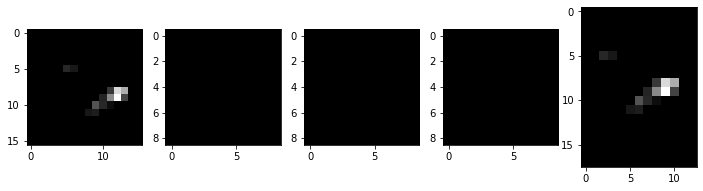

In [85]:
# Visualize the first 5 ROI's feature map (for each feature map, only show the 1st channel of d=512)
# Pooling 이전 크기가 달랐던 5개의 feature
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = im[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp, cmap='gray')
    figNo +=1
plt.show()


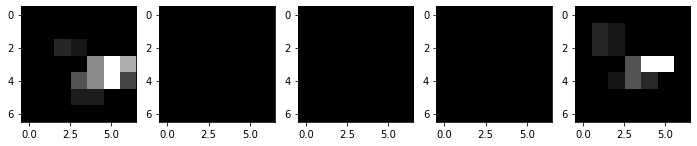

In [86]:
# Visualize the first 5 ROI's feature maps after ROI pooling (for each feature map, only show the 1st channel of d=512)
# Pooling 이후 크기가 같아진 5개의 feature
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = adaptive_max_pool(im)[0]
    tmp = tmp[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp, cmap='gray')
    figNo +=1
plt.show()


In [87]:
# 그림 : 앞에서 pooling을 통해 size가 같아진 것을 알주는 그림
# 노랑, 주황색 역시 크기가 달랐지만 average_max_pooling으로 크기가 같아진 것처럼 우리의 feature들도 크기가 같아짐

In [88]:
#Reshape the tensor so that we can pass it through the feed forward layer.
# 25088 =  7 x 7 x 512의 feature를 1차원으로 펴줌
# 드디어 training을 위한 밑작업 끝. 핀 data를 detector 모델에 돌려주면 모델이 training 할거임
k = output.view(output.size(0), -1)
print(k.shape) # 25088 = 7*7*512


torch.Size([128, 25088])


# Detection 모델 training & loss 계산

In [89]:
# 먼저 roi_head_classifier라는 모델에서 1번의 NN layer를 거친 후 밑에 있는 loc와 score로 보내줌
# loc는 location 모델, 즉, 좌표를 알려주는 모델 -> true box가 2개 있으니 1 box당 좌표가 4개 총 8개의 좌표를 가짐
# score는 object 판별 모델, 즉, object가 있을 확률을 알려줌 -> true box가 2개 있으니 score도 2개 

roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096), nn.Linear(4096, 4096)]).to(device)
cls_loc = nn.Linear(4096, 2 * 4).to(device) # (1 classes 모자 + 1 background. Each will have 4 co-ordinates)
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

score = nn.Linear(4096, 2).to(device) # (1 classes, 모자 + 1 background)


In [90]:
# passing the output of roi-pooling to ROI head 
# 출력값이 loc는 8, score는 2로 잘 나오는 것을 확인
# 128은 training sample의 수

k = roi_head_classifier(k.to(device))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)
print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([128, 8]) torch.Size([128, 2])


In [91]:
# predicted
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

#actual
print(gt_roi_locs.shape)
print(gt_roi_labels.shape)

torch.Size([128, 8])
torch.Size([128, 2])
(128, 4)
(128,)


In [92]:
gt_roi_labels


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [93]:
# True 값을 torch형태로 변환 중
# Converting ground truth to torch variable
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

# 분류 loss를 계산
#Classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)
print(roi_cls_loss.shape)


torch.Size([128, 4]) torch.Size([128])
torch.Size([])


In [94]:
# positive RoI만 가지고 좌표(regresssion) loss 계산

# Regression loss
n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

# For Regression we use smooth L1 loss as defined in the Fast RCNN paper
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)
print(mask.shape)

# take those bounding boxes which have positve labels
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
roi_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x-0.5))
print(roi_loc_loss.sum())


torch.Size([128, 2, 4])
torch.Size([128, 4])
torch.Size([128, 4])
torch.Size([12, 4]) torch.Size([12, 4])
tensor(1.2703, dtype=torch.float64, grad_fn=<SumBackward0>)


In [95]:
# lambda(하이퍼파라미터)를 10으로 설정한 cls_loss와 loc_loss의 가중 합 
# 즉, detector의 loss

roi_lambda = 10.
roi_loss = roi_cls_loss + (roi_lambda * roi_loc_loss)
print(roi_loss)


tensor([[0.7579, 0.7134, 0.7722, 1.0872],
        [0.6897, 0.7892, 0.9380, 0.9306],
        [1.0257, 1.0365, 0.8319, 0.7485],
        [0.7219, 0.8718, 0.9989, 0.7020],
        [0.6909, 0.7621, 0.7495, 0.7026],
        [1.3174, 0.6909, 1.5598, 2.1159],
        [0.7008, 0.7051, 2.4979, 1.4989],
        [1.8730, 0.6899, 0.7257, 0.6895],
        [0.7344, 1.4524, 0.6939, 0.7292],
        [0.7378, 0.7499, 0.6893, 0.6891],
        [1.1079, 0.6898, 0.8464, 0.6903],
        [1.9227, 0.9996, 0.7558, 0.7043]], dtype=torch.float64,
       grad_fn=<AddBackward0>)


In [96]:
#여기는 RPN과 detector의 loss의 총 합 (전체 모델의 loss)
total_loss = rpn_loss + roi_loss
print(total_loss)

tensor([[2.5408, 2.4963, 2.5552, 2.8701],
        [2.4726, 2.5721, 2.7210, 2.7135],
        [2.8086, 2.8194, 2.6148, 2.5314],
        [2.5049, 2.6547, 2.7818, 2.4849],
        [2.4739, 2.5450, 2.5324, 2.4856],
        [3.1003, 2.4738, 3.3428, 3.8988],
        [2.4838, 2.4880, 4.2809, 3.2819],
        [3.6559, 2.4729, 2.5086, 2.4725],
        [2.5174, 3.2354, 2.4768, 2.5122],
        [2.5207, 2.5328, 2.4723, 2.4720],
        [2.8908, 2.4727, 2.6293, 2.4733],
        [3.7057, 2.7826, 2.5387, 2.4873]], dtype=torch.float64,
       grad_fn=<AddBackward0>)
